# Modelowanie ARMA

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

#from ts_utils import check_time_series_stationary
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# from statsmodels.tsa.stattools import adfuller
# def check_time_series_stationary(y, rolling_len = 12):
    
#     y = pd.Series(y)
    
#     df_test = adfuller(y)
    
#     if df_test[1] < 0.05:
#         print('Szereg jest stacjonarny')
#     else:
#         print('Szereg jest niestacjonarny')
    
#     print("{0:^32s}".format("Dickey-Fuller Test"))
#     print("-"*32+"\n")
    
#     print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
#     print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
#     print("-"*32+"\n")
    
#     rolling_mean = y.rolling(rolling_len).mean()
#     rolling_var = y.rolling(rolling_len).var()

#     plt.plot(y)
#     plt.plot(rolling_mean, label="Rolling mean")
#     plt.plot(rolling_var, label="Rolling var")
#     plt.legend()
#     plt.show()
    
#     print("{0:^32s}".format("Autocorrelation plot"))
#     print("-"*32+"\n")
#     pd.plotting.autocorrelation_plot(y)
#     plt.show()

## Zadanie 1

Dokonaj analizy szeregu czasowego `Sunspots`. Dopasuj odpowiedni model i dokonaj predykcji.

In [ ]:
print(sm.datasets.sunspots.NOTE) #inne sunspotsy (o dłuższym okresie czasowym)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



[datetime.datetime(1700, 12, 31, 0, 0), datetime.datetime(1701, 12, 31, 0, 0), datetime.datetime(1702, 12, 31, 0, 0), datetime.datetime(1703, 12, 31, 0, 0), datetime.datetime(1704, 12, 31, 0, 0), datetime.datetime(1705, 12, 31, 0, 0), datetime.datetime(1706, 12, 31, 0, 0), datetime.datetime(1707, 12, 31, 0, 0), datetime.datetime(1708, 12, 31, 0, 0), datetime.datetime(1709, 12, 31, 0, 0), datetime.datetime(1710, 12, 31, 0, 0), datetime.datetime(1711, 12, 31, 0, 0), datetime.datetime(1712, 12, 31, 0, 0), datetime.datetime(1713, 12, 31, 0, 0), datetime.datetime(1714, 12, 31, 0, 0), datetime.datetime(1715, 12, 31, 0, 0), datetime.datetime(1716, 12, 31, 0, 0), datetime.datetime(1717, 12, 31, 0, 0), datetime.datetime(1718, 12, 31, 0, 0), datetime.datetime(1719, 12, 31, 0, 0), datetime.datetime(1720, 12, 31, 0, 0), datetime.datetime(1721, 12, 31, 0, 0), datetime.datetime(1722, 12, 31, 0, 0), datetime.datetime(1723, 12, 31, 0, 0), datetime.datetime(1724, 12, 31, 0, 0), datetime.datetime(1725, 

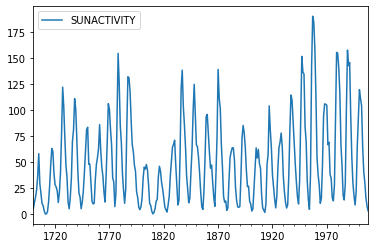

In [ ]:
sunspots = sm.datasets.sunspots.load_pandas().data
print(sm.tsa.datetools.dates_from_range('1700', '2008'))
sunspots.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
sunspots = sunspots.drop('YEAR', axis=1)

sunspots.plot() #mamy okres

In [ ]:
sunspots

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0
...,...
2004-12-31,40.4
2005-12-31,29.8
2006-12-31,15.2
2007-12-31,7.5


Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -2.8378
p-value             :     0.0531
--------------------------------



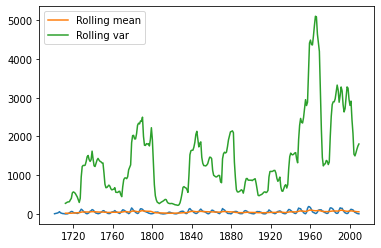

      Autocorrelation plot      
--------------------------------



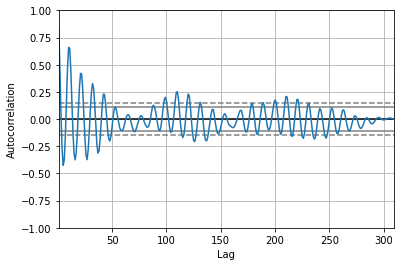

In [ ]:
check_time_series_stationary(sunspots.SUNACTIVITY)

In [ ]:
# Na poziomie istotnosci 10% zakładamy, że szereg jest stacjonarny, choć tak naprawdę z wykresów acfów widać, że nie jest najlepiej

### Dopasowanie modelu

Diagnostyka modelu sprowadza się m.in do:
- analizy reszt - jeśli dopadowany model poprawnie wyjaśnia dynamikę czasową analizowanego zjawiska, w szeregu reszt nie powinno być widać żadnych regularnych zachowań (trendu, sezonowości), ani istotnej korelacji czasowej (dla żadnego z opóźnień), stąd:
    - w praktyce możemy posługiwać się regułą, że reszty dopasowanego modelu powinny zachowywać się w przybliżeniu jak biały szum,
    - często weryfikujemy również dodatkowo, czy rozkład reszt można uznawać za rozkład normalny
    
W praktyce sprawdzamy najczęściej 
- wykres reszt - na wykresie nie powinno być widocznych regularnych wzorów ani niejednorodności wariancji, 
- test Durbina-Watsona - niezależność błędów obserwacji, dobrze dopasowany model zakłada, że otrzymywane reszty są niezależne od siebie, innymi słowy, rozkład ich jest losowy, przypadkowy, bez stale występującego wzorca. 
- ACF/PACF dla reszt - na wykresach nie powinno być widocznych istotnych korelacji (tzw. *graficzny test białoszumowości*),
- weryfikacja normalności rozkładu reszt - wykorzystujemy narzędzia graficzne (np. Q-Q plot lub histogram) oraz formalne testy statystyczne normalności (np. test Shapiro-Wilka).

### Test Durbina-Watsona

Statystyka DW mieści się w przedziale od 0 do 4:
- w przypadku DW > 2, zakłada się występowanie autokorelacji ujemnej, 
- w przypadku DW < 2 autokorelacji dodatniej,
- wartości zbliżone do 2 oznaczają brak występowania autokorelacji. 

### Wykres reszt za pomocą ACF i PACF

### Weryfikacja normalności rozkładu reszt

1. Test Shapiro-Wilka

    H0: Rozkład badanej cechy jest rozkładem normalnym.

    H1: Rozkład badanej cechy nie jest rozkładem normalnym.
    

2. Wykres $Q-Q$

### Analiza istotności współczynników w modelu

Jakość dopasowania modelu można niekiedy poprawić eliminując te współczynniki, które są statystycznie nieistotne, to znaczy nie odgrywają istotnej roli w wyjaśnianiu dynamiki czasowej modelowanego zjawiska.

Formalnie, sprawdzamy hipotezę zerową postaci 
$$H_0: \phi_i = 0,$$
kontra hipotezie alternatywnej 
$$H_1: \phi_i \neq 0$$.

Odrzucenie $H_0$ przemawia za pozostawieniem współczynnika $\phi_i$ w modelu.

### Dopasowanie (Predykcja) na podstawie modelu

## Zadanie 2
Dla danych

1. `southern`

2. `daily-total-female-births`

dopasuj odpowiedni model $\text{AR}(p)$ lub $\text{MA}(q)$ lub $\text{ARMA}(p, q)$ (rząd $p$ i $q$ wyznacz na podstawie wykresów ACF i PACF). Sprawdź dopasowanie modeli.

In [ ]:
daily_biths = pd.read_csv('daily-total-female-births.csv', 
                 parse_dates=['Date'], index_col='Date')

daily_biths.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [ ]:
daily_biths.index

DatetimeIndex(['1959-01-01', '1959-01-02', '1959-01-03', '1959-01-04',
               '1959-01-05', '1959-01-06', '1959-01-07', '1959-01-08',
               '1959-01-09', '1959-01-10',
               ...
               '1959-12-22', '1959-12-23', '1959-12-24', '1959-12-25',
               '1959-12-26', '1959-12-27', '1959-12-28', '1959-12-29',
               '1959-12-30', '1959-12-31'],
              dtype='datetime64[ns]', name='Date', length=365, freq=None)

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -4.8083
p-value             :     0.0001
--------------------------------



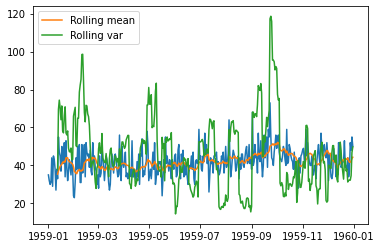

      Autocorrelation plot      
--------------------------------



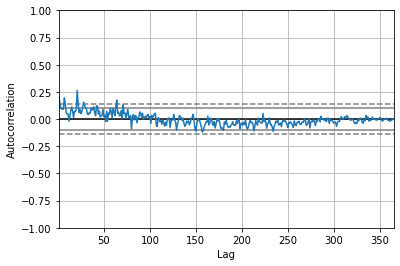

In [ ]:
check_time_series_stationary(daily_biths.Births) #całkiem stacjonarny

# Kryteria informacyjne oceniają jakość dopasowania modelu

Kryteria informacyjne oceniają jakość dopasowania modelu na podstawie danych historycznych, kontrolując jednocześnie stopień złożoności modelu. 

Zwiększając liczbę parametrów modelu (zwiększając złożoność modelu), możemy zazwyczaj otrzymać lepsze dopasowanie modelu do danych. Zbyt dobre dopasowanie modelu może jednak powodować problemy, a w szczególności może prowadzić do złych prognoz. Z tego powodu w postaci kryteriów wyboru modelu występuje składnik kary za wymiar modelu, w ogólności:

$$C(\text{model}) = -2 \ln(L) + \text{kara(liczba współczynników modelu)},$$
gdzie $L$ oznacza funkcję wiarogodności.

**AIC (Akaike Information Criterium)**
$$AIC(p, q) = -2 \ln(L) + 2\cdot(p+q+1)$$

**BIC (Bayesian Information Criterium)**
$$BIC(p, q) = -2 \ln(L) + (p+q+1)\cdot\ln n$$

### Kryteria oceniające dokładność prognoz 

- MSE - Mean Squared Error
- MAE - Median Absolute Error

Należy jednak pamiętać, że w odróżnieniu od kryteriów infromacyjnych, kryteria oparte na błędach predykcji nie mają wbudowanego mechanizmu, który "karałby" za złożoność modelu.

## Zadanie 3

Napisz funkcję, która dla dowolnego szeregu czasowego i modelu `ARMA` sprawdzi jego dopasowanie oraz jakość predykcji na podstawie MSE i MAE.
Zawrzyj informację o wartości oszacowanych współczynników modelu, wartości AIC i BIC, wartości statystyki Durbina-Watsona oraz ocenę normalności reszt.

Następnie sprawdź dopasowanie dla kilku wybranych modeli ARMA.

In [1]:
# def mse(y, yhat):
#     return np.mean((y - yhat) ** 2)

# def mae(y, yhat):
#     return np.median(np.abs(y - yhat))

In [ ]:
# def fit_ARMA(ts, p, q, pred_start, pred_end):
#     arma = ARIMA(ts, order=(p, 0, q)).fit()
    
#     print('AR params %s' % arma.arparams)
#     print('MA params %s' % arma.maparams)
    
#     print('AIC: %.2f, \nBIC: %.2f' % (arma.aic, arma.bic))
    
#     dw_test = sm.stats.durbin_watson(arma.resid)
#     print("Statystyka Durbina-Watsona {}".format(dw_test))
    
#     normal_test = stats.shapiro(arma.resid)
#     print("Pvalue testu Shapiro-Wilka: {}".format(normal_test[1]))
    
#     pred = arma.predict(start=pred_start, end=pred_end,dynamic = True)
        
#     mse_val = mse(ts.values, pred.values)
#     mae_val = mae(ts.values, pred.values)
#     print('MSE: {}'.format(mse_val))
#     print('MAE: {}'.format(mae_val))
    
#     plt.plot(ts)
#     plt.plot(pred, 'g--')
#     plt.show()

# Optymalna wartość $p$ na podstawie kryterium oceniającego dobroć dopasowania modelu (AIC lub BIC)

## Zadanie 4
Napisz funkcję, która dla danego szeregu czasowego wyznaczy najlepszy rząd $p$ modelu $\text{AR}(p)$ na podstawie kryterium AIC i BIC.

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

# def find_the_best_parametr_ar(ts, max_p = 10):
#     aic = np.zeros(max_p)
#     bic = np.zeros(max_p)
#     for i in range(1, max_p + 1):
#         ar = ARIMA(ts, (i, 0, 0)).fit()
#         aic[i-1] = ar.aic
#         bic[i-1] = ar.bic
        
#     plt.plot(range(1, max_p + 1), aic, 'r.-', label="AIC")
#     plt.plot(range(1, max_p + 1), bic, 'g.-', label="BIC")
#     plt.legend()
#     plt.show()
        
#     print("Najlepszy rząd p: {} dla kryterium AIC (AIC={})".format(np.argmin(aic) + 1, np.min(aic)))
#     print("Najlepszy rząd p: {} dla kryterium BIC (BIC={})".format(np.argmin(bic) + 1, np.min(bic)))

## Zadanie 5

Napisz funkcję, która dla danego szeregu czasowego wyznaczy najlepszy rząd $p$ i $q$ modelu $\text{ARMA}(p)$ na podstawie kryterium AIC i BIC.

In [ ]:
# def find_the_best_arma(ts, max_p = 10, max_q=10):
#     aic = np.zeros((max_p, max_q))
#     bic = np.zeros((max_p, max_q))
    
#     for i in range(max_p):
#         for j in range(max_q):
#             arma = ARIMA(ts, order=(i + 1, 0, j + 1)).fit()
#             aic[i, j] = arma.aic
#             bic[i, j] = arma.bic
#             print('ARMA(%d, %d): AIC=%f, BIC=%f' % (i+1, j+1, arma.aic, arma.bic))
            
#     print("-" * 30)
#     min_aic = np.min(aic)
#     min_arg_aic = np.argwhere(aic == min_aic)[0]
#     print("MINIMUM AIC=%f dla p=%d, q=%d" % (min_aic, min_arg_aic[0] + 1, min_arg_aic[1] + 1))
#     min_bic = np.min(bic)
#     min_arg_bic = np.argwhere(bic == min_bic)[0]
#     print("MINIMUM BIC=%f dla p=%d, q=%d" % (min_bic, min_arg_bic[0] + 1, min_arg_bic[1] + 1))

In [ ]:
# find_the_best_arma(sunspots, 5, 5)